# Decision Tree
Creating a decision tree to evaluate rules and factors that lead to suicide. Columns that will be taken into account are attack, weapon type and the property value damage. 

In [35]:
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from matplotlib import pyplot as plt
import graphviz
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('../data/data.csv', encoding="latin-1")
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


# Extract cases that lead to Suicide
For the first implmentation of the Decision Tree, using an uneven set of target columns lead to a one sided tree. As a result, We'll filter by cases that lead to suicide and even out the dataset. 

In [9]:
suicides = df[df["suicide"] == 1]
len(suicides)

6633

In [10]:
non_suicides = df[df["suicide"] == 0]
#non_suicides = non_suicides[1:1822]
non_suicides = non_suicides[1:6633]

In [11]:
frames = [suicides, non_suicides]
result = pd.concat(frames)

In [12]:
feature_cols = ['suicide', 'attacktype1_txt', 'weaptype1_txt', 'propvalue']
inputs = result.filter(feature_cols).dropna()
#inputs = df.filter(["suicide", "attacktype1_txt", "weaptype1_txt","propvalue"]).dropna()
inputs

,suicide,attacktype1_txt,weaptype1_txt,propvalue
35988,1,Bombing/Explosion,Explosives,150000.0
46926,1,Bombing/Explosion,Explosives,300000.0
50574,1,Bombing/Explosion,Explosives,1000000.0
70492,1,Bombing/Explosion,Explosives,-99.0
72475,1,Bombing/Explosion,Explosives,350000000.0
...,...,...,...,...
6607,0,Bombing/Explosion,Explosives,200000.0
6613,0,Armed Assault,Incendiary,3500.0
6619,0,Bombing/Explosion,Explosives,75000.0
6625,0,Facility/Infrastructure Attack,Incendiary,17000.0


# Encoding the data
For building the tree, we're focusing specifically on the attack, weapon type and property value. I'm using Label Encoder to convert the string values to numerical data. 

In [20]:
attack_type = LabelEncoder()
weapon_type = LabelEncoder()
property_value = LabelEncoder()
inputs["attack_n"] = attack_type.fit_transform(inputs["attacktype1_txt"])
inputs["weapontype_n"] = attack_type.fit_transform(inputs["weaptype1_txt"])
inputs["propvalue_n"] = attack_type.fit_transform(inputs["propvalue"])
inputs

,suicide,attacktype1_txt,weaptype1_txt,propvalue,attack_n,weapontype_n,propvalue_n
35988,1,Bombing/Explosion,Explosives,150000.0,2,1,108
46926,1,Bombing/Explosion,Explosives,300000.0,2,1,118
50574,1,Bombing/Explosion,Explosives,1000000.0,2,1,129
70492,1,Bombing/Explosion,Explosives,-99.0,2,1,0
72475,1,Bombing/Explosion,Explosives,350000000.0,2,1,148
...,...,...,...,...,...,...,...
6607,0,Bombing/Explosion,Explosives,200000.0,2,1,112
6613,0,Armed Assault,Incendiary,3500.0,0,3,39
6619,0,Bombing/Explosion,Explosives,75000.0,2,1,96
6625,0,Facility/Infrastructure Attack,Incendiary,17000.0,3,3,68


# Modify the label encoded data
Dropping all the text columns that we don't need anymore. Using numerical features only.

In [21]:
target = inputs["suicide"]
#target

In [22]:
inputs_n = inputs.drop(['attacktype1_txt', 'weaptype1_txt', 'propvalue', 'suicide'], axis='columns')
inputs_n

,attack_n,weapontype_n,propvalue_n
35988,2,1,108
46926,2,1,118
50574,2,1,129
70492,2,1,0
72475,2,1,148
...,...,...,...
6607,2,1,112
6613,0,3,39
6619,2,1,96
6625,3,3,68


# Fitting the model
Using our label encoded data, we call the DecisionTreeClassifer from Sci-Kit and get an accuracy rating. We also plot and visualize the tree using GraphViz. 

In [23]:
model = tree.DecisionTreeClassifier()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(inputs_n, target, test_size=0.2, random_state=1) # 80% training and 20% test

In [25]:
X_train, xval, y_train, yval = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 60% training and 20% 20% validation

In [28]:
#model.fit(inputs_n, target)
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [29]:
model.score(inputs_n, target)

0.9818605856439492

In [36]:
predict = model.predict(X_test)

In [37]:
accuracy_score(y_test, predict)

0.9792746113989638

In [39]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       388
           1       0.96      0.99      0.98       384

    accuracy                           0.98       772
   macro avg       0.98      0.98      0.98       772
weighted avg       0.98      0.98      0.98       772



# Final result
This is the visualize flow chart of the Suicide Classifer. 

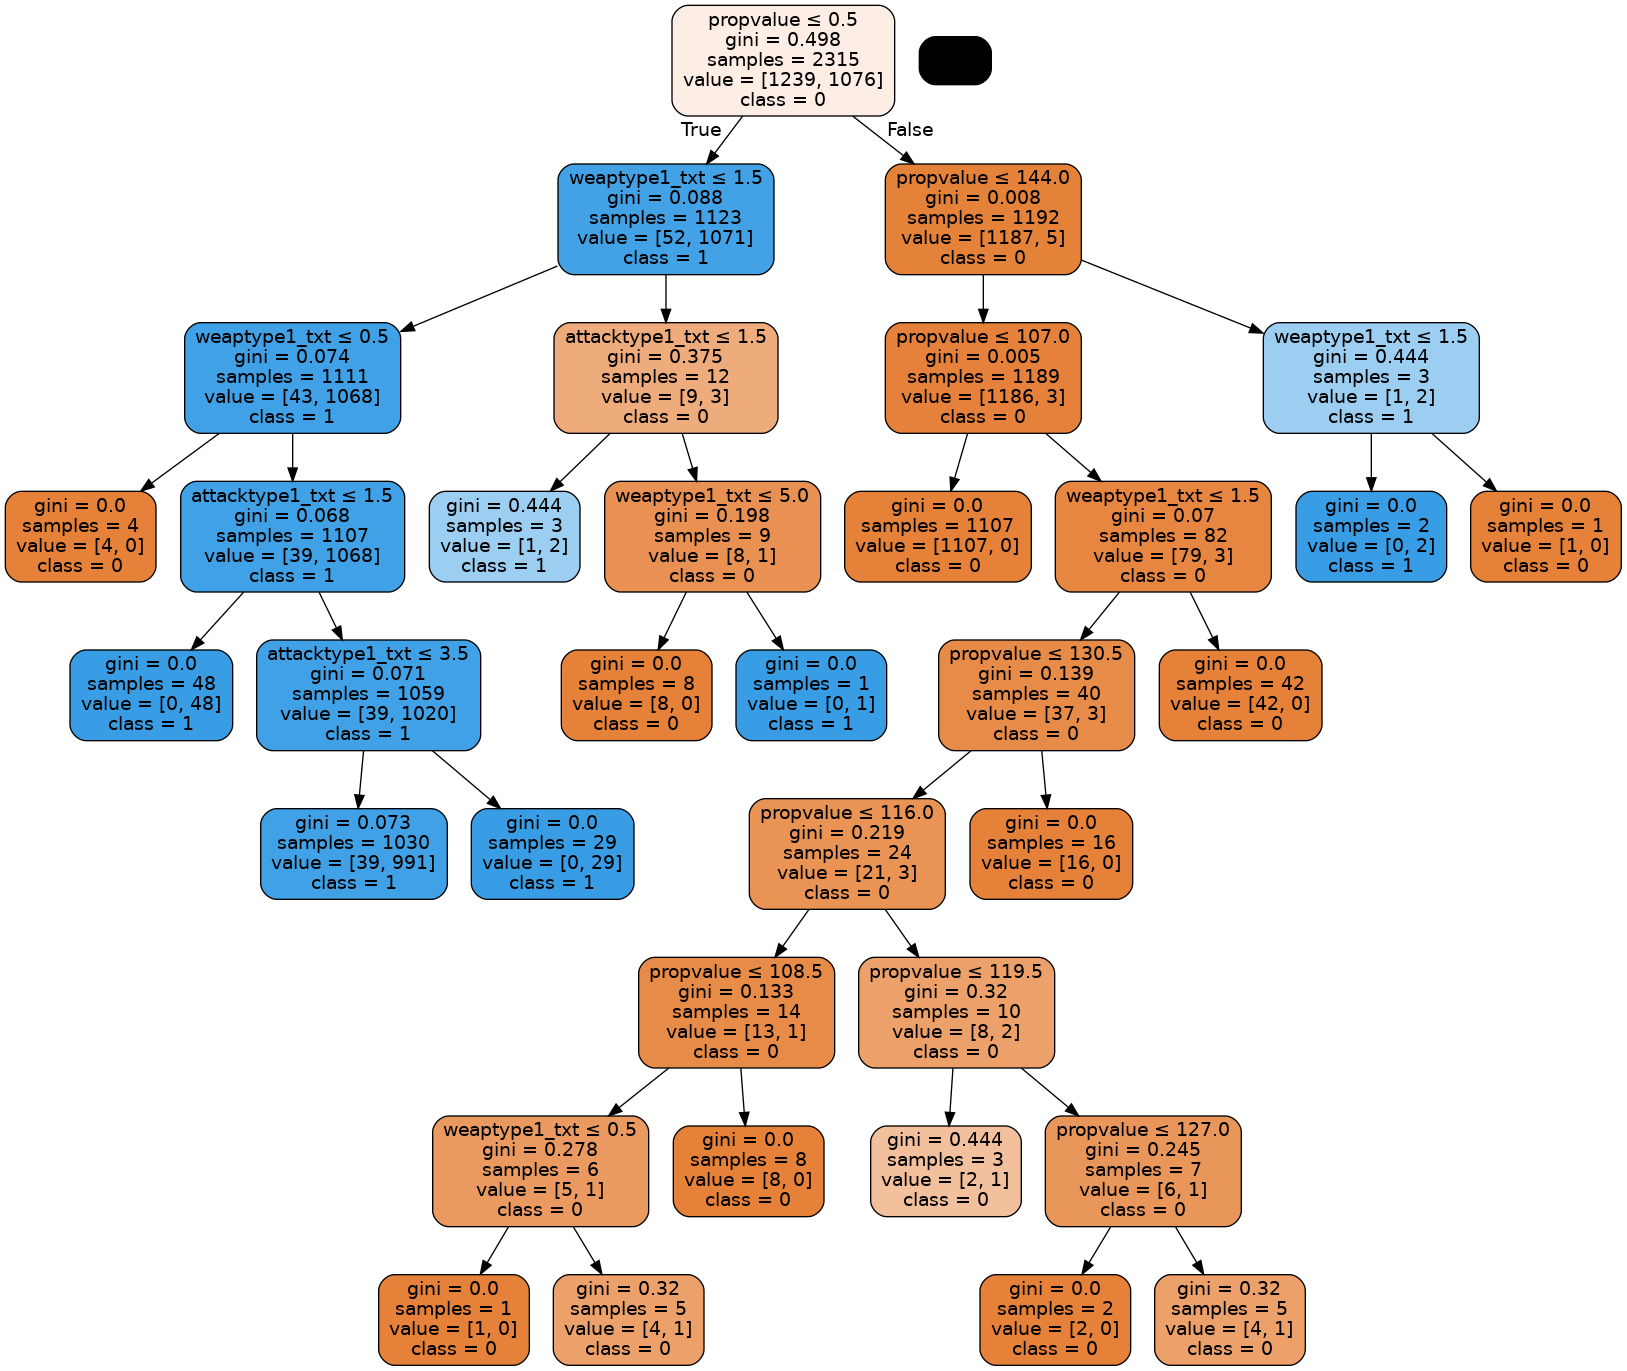

In [30]:
feature_cols = ['attacktype1_txt', 'weaptype1_txt', 'propvalue']
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('suicideClassification.png')
Image(graph.create_png())